# Project notebook **<span style="COLOR:RED">(complete this cell)</span>**


### Student 1 (first half presentation)
Name : Valentin Lapparov
<br>Group : advanced
### Student 2 (second half presentation)
Name : Sacha Izadi
<br>Group : advanced
### Data name : Mercari price suggestion challenge
### Data URL : https://www.kaggle.com/c/mercari-price-suggestion-challenge/download/train.tsv.7z
### Short summary of the project and datasource :
<span style="COLOR:RED">Should be a few lines maximum</span>

# General instructions (this cell might be deleted for submission)
** <span style="color:red"> Write all the project in this file : code and explanations and upload it before January 7th at 23:55 </span> ** : 

<span style="color:red">Remember : Code cells must be smaller than 30 lines </span>

Every thing must be in the notebook :

* Explanation of what you want to do with data should be present in the Notebook
* Download data in the notebook (check the URL availability) and give the source of data (both URL and textual description)
* Give as much as possible characteristics of data (size, type, fields, ...)
* Provide visualisation of the data that you think useful
* Check for the consistence of the dataset (error, missing data,...) and correct and/or delete errors
* **Ask yourself a question that request you to perform an estimation** (for example, you can choose a data depending on time, and try to predict the latest 10% of data knowing the rest of data). **This will typically be solved through the proposal of a model and fitting the parameters of the model to (part of) the data.**

If you end up writing long chunks of code, make sure you split it in logical «smaller code cells» and explain the logic. The Juptyer Notebook will be **both the memoire** you will submit for evaluation **and the visual support** for your oral presentation of your project, keep this in mind while writing it.

### Aims : 
** <span style="color:red"> Here explain what you what to do with data</span> ** 
* 
* 
* 

In [1]:
######## Import useful libraries ###########

### pip install some packages //////// uncomment the following lines if necessary.
#! pip install squarify
#! pip install wordcloud

import urllib.request as ur
import pandas as pd
import pickle
import seaborn as sns #seaborn is a library for plotting densities
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import squarify
from scipy import stats
from wordcloud import WordCloud
import nltk
import re

%matplotlib inline 

### Download : 
** <span style="color:red">Write explanations here</span> ** 
* 
* 
* 

In [24]:
######## donwload data from its source ###########
import urllib.request as ur

print('Downloading data...')
data_file = 'train_tsv.7z'
ur.urlretrieve ("https://www.kaggle.com/c/mercari-price-suggestion-challenge/download/train.tsv.7z", data_file)
print('Download complete.')

Download complete.


** <span style="color:red">If there is any obvious data curation to be performed upon initial data loading, do it here</span> ** 



In [30]:
####### unzip file ###########

# >>> Uncomment the following line to install the packages needed for unzipping
#! pip install pyunpack
#! pip install patool
from pyunpack import Archive
data_file = 'train_tsv.7z'
print('Unzipping')
#Archive(data_file).extractall('Data',auto_create_dir=True)
print('Done!')



### >>> Actually we have an issue when unzipping the file ... we had to do it by hand !


Unzipping
Done!


In [2]:
# Load the data set in a pandas DataFrame

print("Loading the dataset in a pandas DataFrame...")
data_mercari = pd.read_csv('Data/Mercari_data.tsv', sep='\t')
print("Loading completed.")

Loading the dataset in a pandas DataFrame...
Loading completed.


In [3]:
# 1st Sanity check :
data_mercari.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [4]:
data_mercari.drop('train_id',axis=1,inplace=True) ## We remove train_id because it's useless
data_mercari.dtypes #Have a first check of the consistency of the data type (eg.  spot if prices are saved as character strings)

name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [5]:
# Let's check the proportion of missing data (NaN) in the dataset
print ("Percentage of NaN in the dataset (in %)")
print(data_mercari.isnull().sum()/data_mercari.size*100)

Percentage of NaN in the dataset (in %)
name                 0.000000
item_condition_id    0.000000
category_name        0.060967
brand_name           6.096527
price                0.000000
shipping             0.000000
item_description     0.000039
dtype: float64


In [6]:
# As there is only few NaN, removing them won't change the analysis too much
data_mercari=data_mercari[pd.notnull(data_mercari['item_description'])]
data_mercari=data_mercari[pd.notnull(data_mercari['category_name'])]
data_mercari=data_mercari[pd.notnull(data_mercari['brand_name'])]

In [7]:
# Let's split the categories like "Electronics/Computers & Tablets/Components & Parts" into main & sub categories (1 & 2)
data_mercari['main_cat'], data_mercari['subcat_1'], data_mercari['subcat_2'] = \
data_mercari['category_name'].str.split('/', 2).str

In [9]:
# Let's put some order in the columns of the dataset
data_mercari.drop('category_name',axis=1,inplace=True)
cols = data_mercari.columns.values.tolist()
cols = cols[0:2] + cols[-3:] + cols[2:6]
data_mercari = data_mercari[cols]

In [12]:
data_mercari.head(3)

,name,item_condition_id,main_cat,subcat_1,subcat_2,brand_name,price,shipping,item_description
1,Razer BlackWidow Chroma Keyboard,3,Electronics,Computers & Tablets,Components & Parts,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women,Tops & Blouses,Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
6,Acacia pacific tides santorini top,3,Women,Swimwear,Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...


In [13]:
# Pickling the cleaned data for using it later on
data_mercari.to_pickle("data_mercari_removeNanSeparateCat.pickle")

In [14]:
# Opening the pickle data
with open('data_mercari_removeNanSeparateCat.pickle', 'rb') as f:
    data_mercari = pickle.load(f)

### Data charaterisctics :  Here, give as much as possible characteristics of data
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

# Price analysis

Let's first do some basic statistics on the `price` variable. 
* We see that most of the prices lie between \$0 and \$30.
* But some items are sold for free (min=\$0) whereas others are very expensive (max=\$2009) !

In [15]:
data_mercari.price.describe()

count    846982.000000
mean         30.917965
std          44.742851
min           0.000000
25%          12.000000
50%          20.000000
75%          34.000000
max        2009.000000
Name: price, dtype: float64

To better see it we plot the density of price using the library `seaborn` based on matplotlib and specially designed for statistical vizualisation.

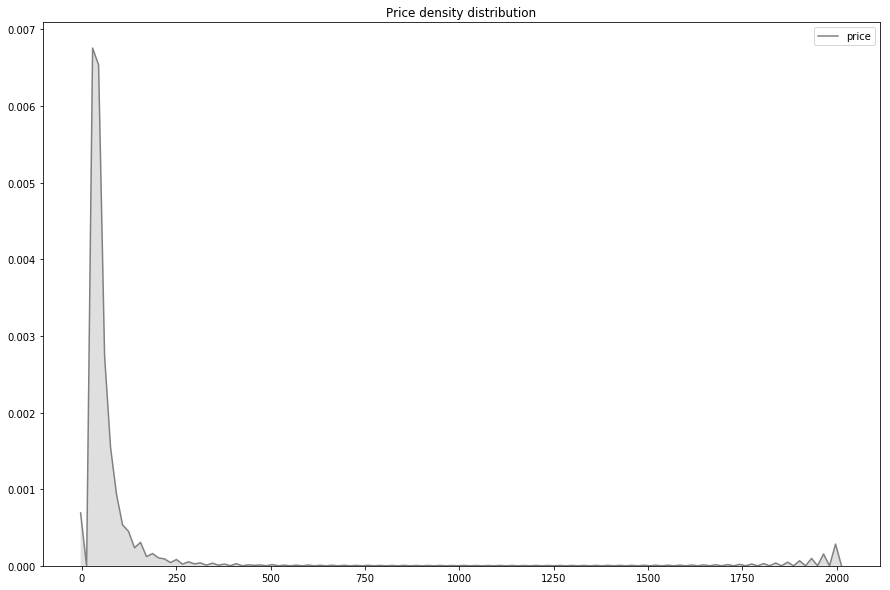

In [16]:
plt.figure(figsize=(15,10)) 
plt.title('Price density distribution')
sns.kdeplot(data_mercari['price'], shade=True, color="grey")

plt.show()

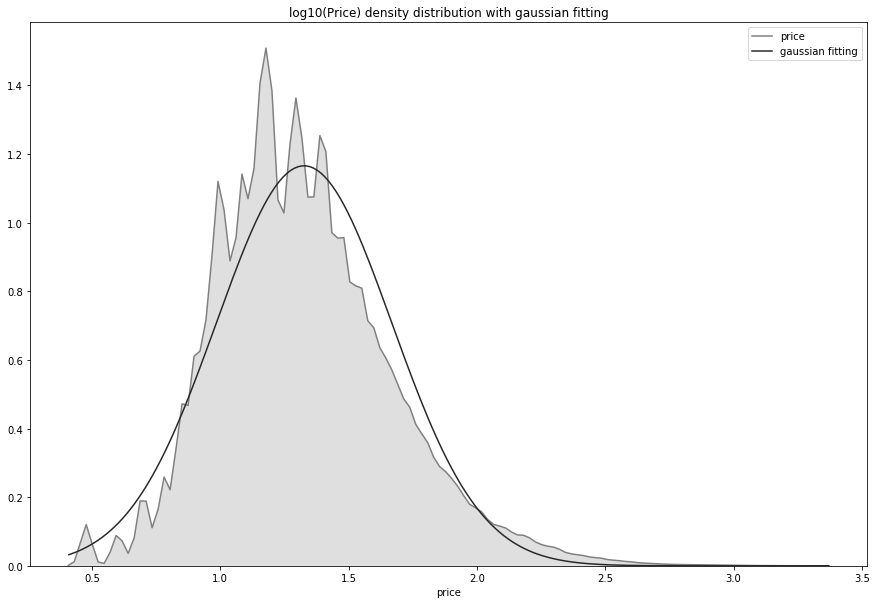

In [18]:
# As prices varie between $0 and $2000 with a high concentration around $30, we can have a better view 
# by plotting the log10(price) density distribution

plt.figure(figsize=(15,10)) 
plt.title('log10(Price) density distribution with gaussian fitting')
sns.kdeplot(np.log10(data_mercari.price[data_mercari.price!=0]), shade=True, color="grey")
sns.distplot(np.log10(data_mercari.price[data_mercari.price!=0]), hist=False, kde = False, fit=stats.norm, label='gaussian fitting')
plt.legend()
plt.show()

Let's see who the outliers (`price` = \$0 and `price` > \$1900) are.

In [19]:
pd.DataFrame.head(data_mercari[data_mercari.price==0])

,name,item_condition_id,main_cat,subcat_1,subcat_2,brand_name,price,shipping,item_description
2544,Levi leggings,3,Women,Jeans,"Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
5237,Nursing Bra,3,Women,Underwear,Bras,Motherhood Maternity,0.0,0,Used a few times but was not able to nurse
7116,Nike Dri-Fit High Power Speed Tights,1,Women,Athletic Apparel,"Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N..."
12738,Beautiful Janie and Jack loafers sz 4,2,Kids,Boys 2T-5T,Shoes,Janie and Jack,0.0,0,Like New
19909,Obey Floral Snapback Hat,2,Men,Men's Accessories,Hats,Obey,0.0,0,A friend sold me this hat although I don't wea...


In [20]:
data_mercari[data_mercari.price > 1900]

,name,item_condition_id,main_cat,subcat_1,subcat_2,brand_name,price,shipping,item_description
180749,NEW apple products,1,Electronics,Cell Phones & Accessories,Cell Phone Accessories,Apple,1909.0,0,"bundle includes: ipad pro keyboard, iphone 6S ..."
415027,Chanel Classic Jumbo Single flap bag,3,Women,Women's Handbags,Shoulder Bag,Chanel,2000.0,1,Authentic. Pre-loved in Excellent Condition. P...
742113,Chanel Chevron Fuschia Pink 2,1,Women,Women's Handbags,Shoulder Bag,Chanel,2000.0,1,Authentic Brand new The price for this is [rm]...
760469,NEW Chanel WOC Caviar Gold Hardware,1,Women,Women's Handbags,Shoulder Bag,Chanel,2009.0,0,"New with tag, box and dustbag but no receipt. ..."
778940,Mary kay,1,Beauty,Makeup,Face,Mary Kay,2000.0,1,30 time wise sets Oily to combo skin
956343,Chanel Black wallet on chain,1,Women,Women's Handbags,Messenger & Crossbody,Chanel,2000.0,1,Lambskin Color is Black with dark Silver Hardw...
1250053,Brand New Chanel CC Quilted WOC,2,Women,Women's Handbags,Messenger & Crossbody,Chanel,2000.0,1,This is a brand new Chanel CC Quilted Wallet o...
1262245,NEW-Chanel Boy Wallet o Chain WOC Caviar,1,Women,Women's Handbags,Messenger & Crossbody,Chanel,2006.0,0,Brand: Chanel Style: WOC Boy Wallet on Chain T...
1393600,David Yurman Wheaton ring,2,Women,Jewelry,Rings,David Yurman,2004.0,0,David Yurman Wheaton wing. Size 6. Original re...


We see that the very expensive outliers are consistent with the item sold (luxury goods) whereas the free items are not. We will drop all free items in order to keep consistency of the dataset!

In [21]:
data_mercari = data_mercari[data_mercari.price != 0]
print("Minimum price is now: $",min(data_mercari.price),": No item is free anymore.")

Minimum price is now: $ 3.0 : No item is free anymore.


In [22]:
# We save the result of this 2nd cleaning in a new pickle file
data_mercari.to_pickle("data_mercari_removeNanSeparateCat_removeFree.pickle")

# Shipping

Let's analyse the influence of `shipping` fees on the `price` of the items sold, by plotting the density distribution of $\log_{10}(price)$ in each sub-group `shipping==1` & `shipping==0`.

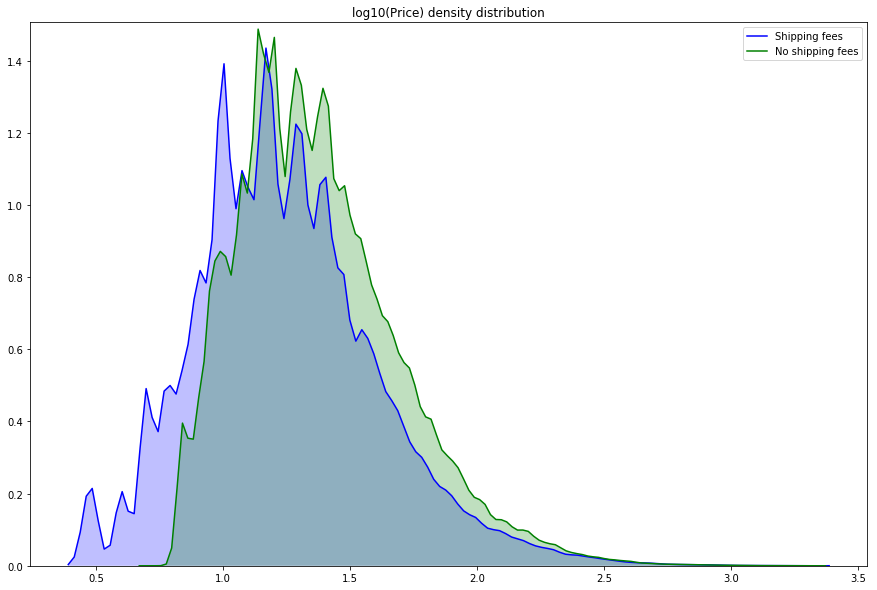

In [23]:
plt.figure(figsize=(15,10))
plt.title('log10(Price) density distribution')
#plt.legend()
sns.kdeplot(np.log10(data_mercari.price[data_mercari.shipping==1]), shade=True, color="blue", label='Shipping fees')
sns.kdeplot(np.log10(data_mercari.price[data_mercari.shipping==0]), shade=True, color="green", label='No shipping fees')

plt.show()

As expected, items with low `prices` require to pay a shipping fee more often than high `prices`. Indeed with high `prices` vendors can lower their margin to bear the cost of shipping.

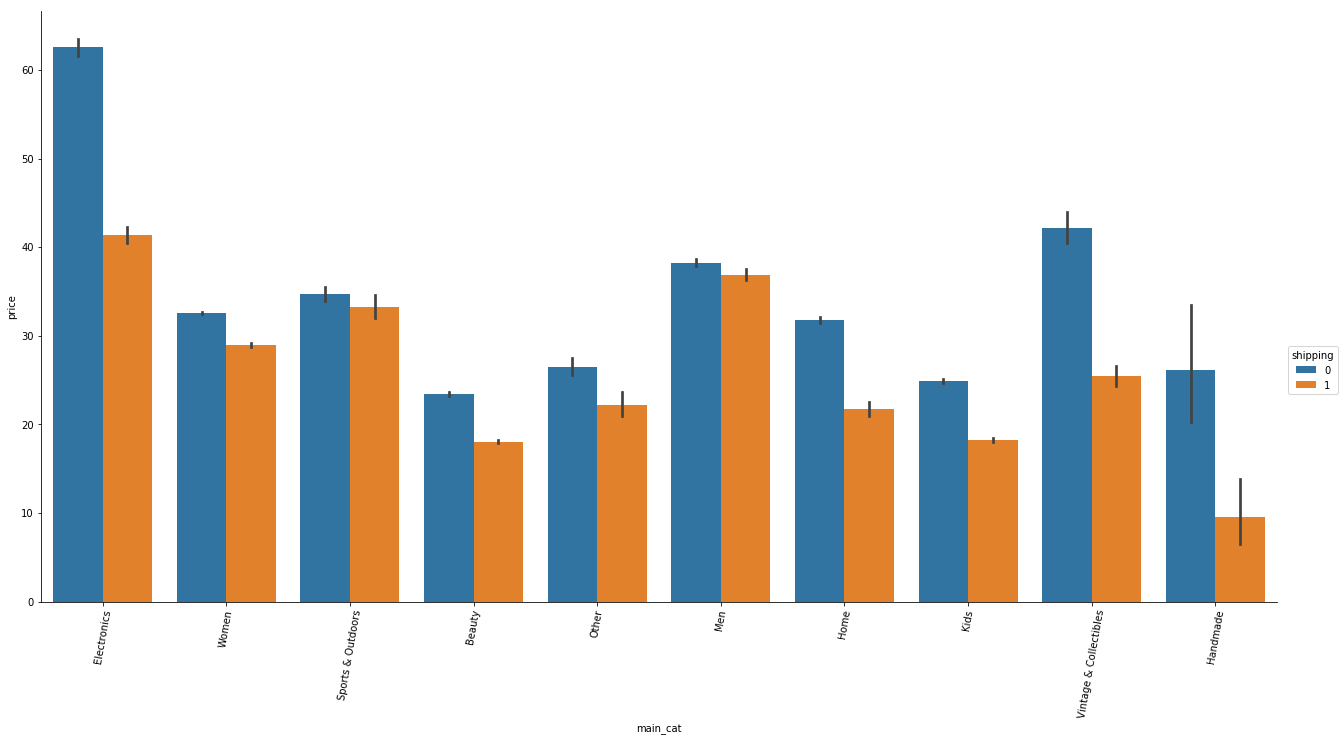

In [24]:
# Price for category with and without shiping

temp = sns.factorplot(x='main_cat', y='price', hue='shipping', data=data_mercari, size=9, aspect=2, kind='bar');
temp.set_xticklabels(rotation=80);

# Item condition

We represent the boxplot of `log10(price)` for the different item conditions (1 being an excellent condition, 5 being a not-so-good condition). Surprisingly, we observe that the overall price distribution is relatively non-sensitive to the item condition.

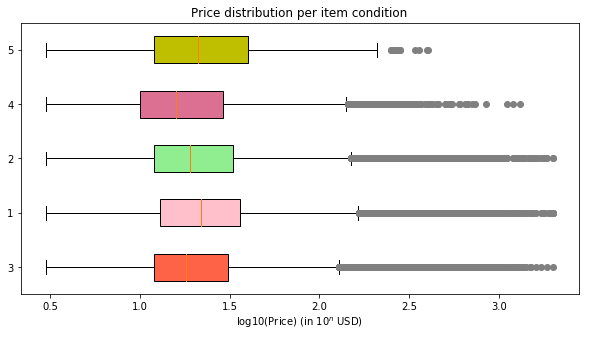

In [39]:
# BoxPlot per item_condition category
plt.figure(figsize=(10,5)) 

plt.title('Price distribution per item condition')
toPlot = [np.array(np.log10(data_mercari.price[data_mercari.item_condition_id==condition])) for condition in data_mercari.item_condition_id.unique()]
bplot = plt.boxplot(toPlot, 0, 'grey', 0, patch_artist=True)
plt.xlabel('log10(Price) (in $10^n$ USD)')
plt.yticks(range(1,6),data_mercari.item_condition_id.unique())

colors = ['tomato','pink','lightgreen','palevioletred','y']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

But it would be a mistake to believe that `item_condition_id` has no impact on the price of the items sold. We take the example of the iPhone, and we see that the better condition the item is, the greater the price.

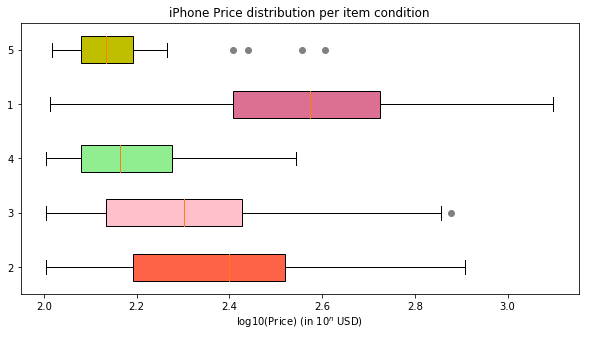

In [53]:
# We can select ± iPhone items by looking for item names containing 'iphone' which prices are greater than $100
def findIphone(string):
    return(string.lower().find('iphone')>=0)

mercari_iphone = data_mercari[data_mercari.name.map(findIphone)]
mercari_iphone = mercari_iphone[mercari_iphone.price>100]


# BoxPlot per item_condition
plt.figure(figsize=(10,5)) 

plt.title('iPhone Price distribution per item condition')
toPlot = [np.array(np.log10(mercari_iphone.price[mercari_iphone.item_condition_id==condition])) for condition in mercari_iphone.item_condition_id.unique()]
bplot = plt.boxplot(toPlot, 0, 'grey', 0, patch_artist=True)
plt.xlabel('log10(Price) (in $10^n$ USD)')
plt.yticks(range(1,6),mercari_iphone.item_condition_id.unique())

colors = ['tomato','pink','lightgreen','palevioletred','y']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

# Categories

In [54]:
print("There are ", data_mercari.main_cat.nunique()," main categories.")
print("There are ", data_mercari.subcat_1.nunique()," sub-categories of level 1.")
print("There are ", data_mercari.subcat_2.nunique()," sub-categories of level 2.")

There are  10  main categories.
There are  104  sub-categories of level 1.
There are  670  sub-categories of level 2.


In [ ]:
# Je voudrais faire un tree map dynamic pour visualiser les subcat mais j'y arrive pas ...
# collapsible trees avec D3.js

Let's visualize how data is distributed among the main categories, by plotting a pie chart and a treemap.
We see that more than half of the data is concentrated in the `Women` main category, followed by `Beauty`, `Kids` and `Men`. 

Text(0,0.5,'')

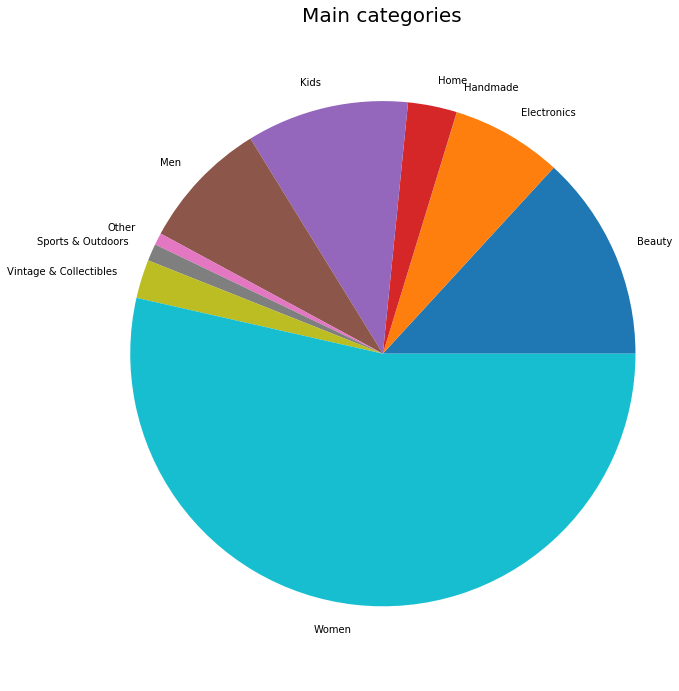

In [55]:
# Pie chart : 
plt.figure(figsize = (10,12))
data_mercari.name.groupby(data_mercari.main_cat).count().plot(kind = 'pie')
plt.title ('Main categories', fontsize = 20)
plt.axis('equal')
plt.ylabel('')

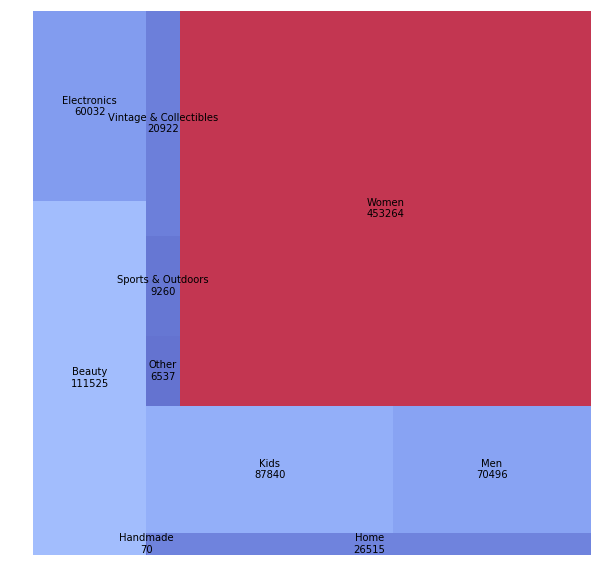

In [56]:
# Tree map : 
nb_items_main_cat = data_mercari.groupby('main_cat').agg('count')

# create a color palette, mapped to these values
mini=min(nb_items_main_cat.name)
maxi=max(nb_items_main_cat.name)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.coolwarm
colors = [cmap(norm(value)) for value in nb_items_main_cat.name]

plt.figure(figsize=(10,10))
labels = ["%s\n%d" % (label) for label in zip(nb_items_main_cat.index, nb_items_main_cat.name)]
squarify.plot(sizes=nb_items_main_cat.name, label=labels, color=colors, alpha=.8)
plt.axis('off')
plt.show()

We will also use a TreeMap to see the distribution of data within the top 20 subcategories_1. As expected we see that most of these subcategories are fashion-related.

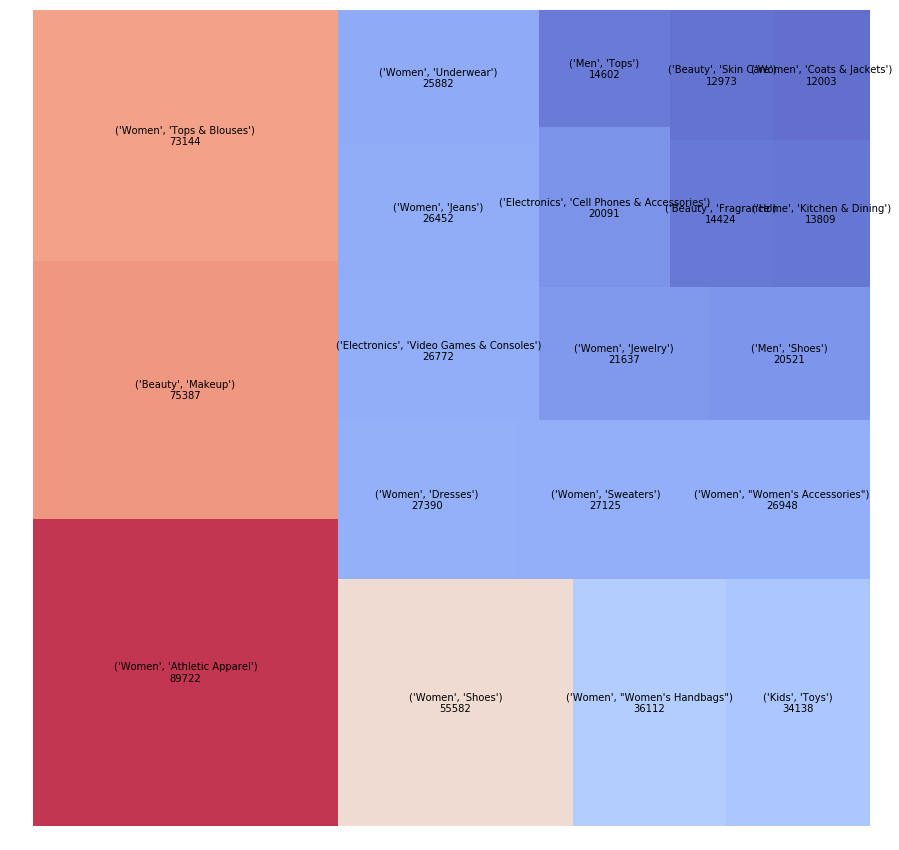

In [57]:
nb_items_subcat1 = data_mercari.groupby(('main_cat','subcat_1')).agg('count')

toPlot = nb_items_subcat1.sort_values('name', ascending=0).head(20)

mini=min(toPlot.name)
maxi=max(toPlot.name)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.coolwarm
colors = [cmap(norm(value)) for value in toPlot.name]


labels = ["%s\n%d" % (label) for label in zip(toPlot.index, toPlot.name)]

plt.figure(figsize=(15,15))
squarify.plot(sizes=toPlot.name, label=labels, color=colors, alpha=.8)
plt.axis('off')

plt.show()

Let's analyse the influence of `main_cat` & `subcat_1` on `price` by plotting the boxplot of the repartition of `price` within these different categories.

We see that :
* categories are little correlated with the distribution of `log10(price)` as the boxplots are relatively similar.
* some categories have more outliers (i.e. luxury goods) than others

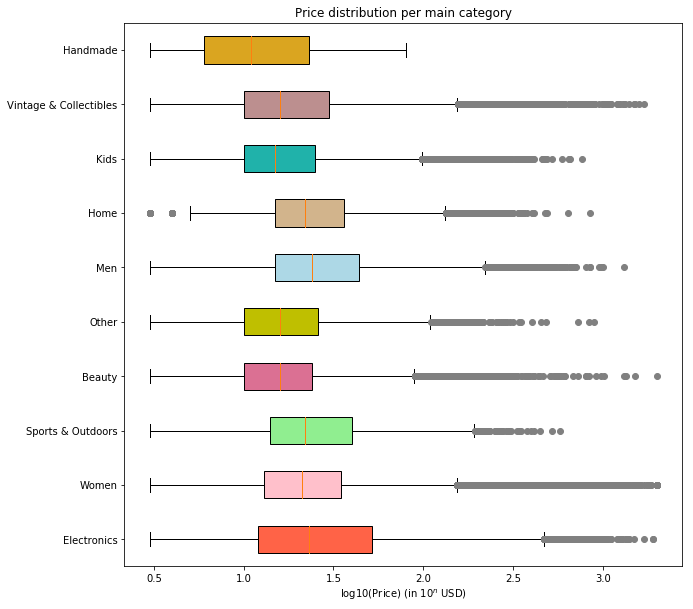

In [58]:
# BoxPlot per main category
plt.figure(figsize=(10,10)) 

plt.title('Price distribution per main category')
toPlot = [np.array(np.log10(data_mercari.price[data_mercari.main_cat==m])) for m in data_mercari.main_cat.unique()]
bplot = plt.boxplot(toPlot, 0, 'grey', 0, patch_artist=True)
plt.xlabel('log10(Price) (in $10^n$ USD)')
plt.yticks(range(1,11),data_mercari.main_cat.unique())

colors = ['tomato','pink','lightgreen','palevioletred','y','lightblue','tan','lightseagreen','rosybrown','goldenrod']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

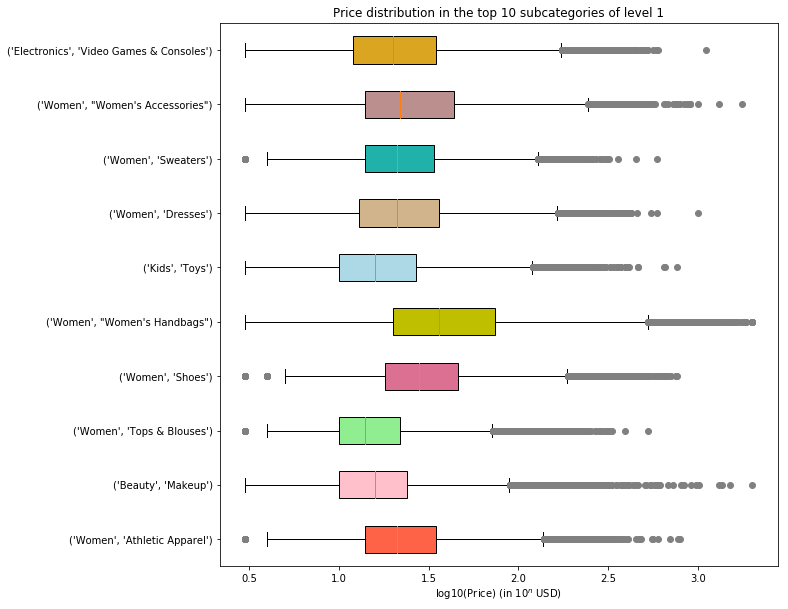

In [59]:
# BoxPlot per sub category of level 1

nb_items_subcat1 = data_mercari.groupby(('main_cat','subcat_1')).agg('count')
subcat_toPlot = nb_items_subcat1.sort_values('name', ascending=0).head(10).index


plt.figure(figsize=(10,10)) 

plt.title('Price distribution in the top 10 subcategories of level 1')
toPlot = [np.array(np.log10(data_mercari.price[data_mercari.main_cat==subcat_toPlot[i][0]][data_mercari.subcat_1==subcat_toPlot[i][1]]))\
          for i in range(10)]

bplot = plt.boxplot(toPlot, 0, 'grey', 0, patch_artist=True)
plt.xlabel('log10(Price) (in $10^n$ USD)')
plt.yticks(range(1,11),[subcat_toPlot[i] for i in range(10)])

colors = ['tomato','pink','lightgreen','palevioletred','y','lightblue','tan','lightseagreen','rosybrown','goldenrod']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

# Brand name

In [60]:
print("There are %d unique brand names in the training dataset." % data_mercari['brand_name'].nunique())

There are 4789 unique brand names in the training dataset.


In [61]:
#
nb_items_brand = data_mercari.groupby('brand_name').agg('count')
print("The 30 brands with the largest number of items on store are: \n", \
      nb_items_brand.sort_values('name', ascending=0).head(30).index)

The 30 brands with the largest number of items on store are: 
 Index(['Nike', 'PINK', 'Victoria's Secret', 'LuLaRoe', 'Apple', 'FOREVER 21',
       'Nintendo', 'Lululemon', 'Michael Kors', 'American Eagle', 'Rae Dunn',
       'Sephora', 'Coach', 'Bath & Body Works', 'Disney', 'Adidas', 'Funko',
       'Under Armour', 'Sony', 'Old Navy', 'Hollister', 'Carter's',
       'Urban Decay', 'The North Face', 'Independent', 'Too Faced', 'Xbox',
       'Brandy Melville', 'Kate Spade', 'MAC'],
      dtype='object', name='brand_name')


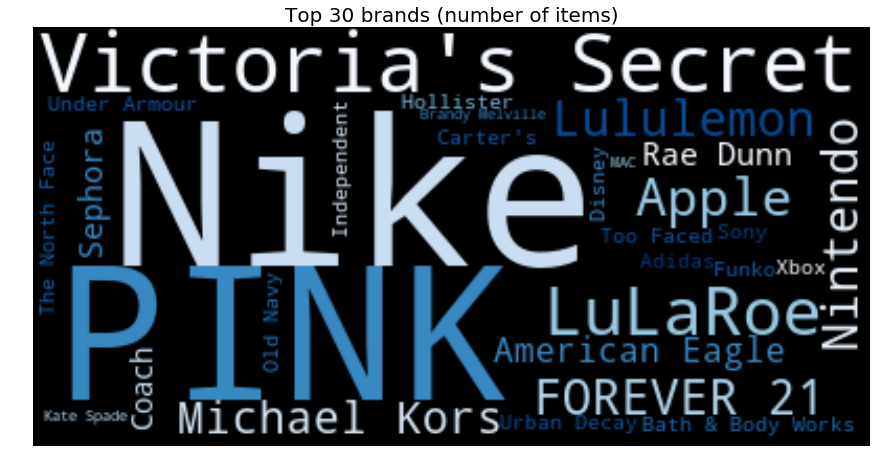

In [62]:
# For better visualization let's plot a WordCloud on the 30 brands with the largest number of items on store
# The size of each word corresponds to its frequency


# Computing the standardized frequency of each word
brand_freq = nb_items_brand.sort_values('name', ascending=0).head(30).name
brand_freq /= sum(brand_freq)
freq = brand_freq.to_dict()


w=WordCloud(colormap='Blues')
w.generate_from_frequencies(frequencies = freq)
plt.figure(figsize=(15,15))
plt.title('Top 30 brands (number of items)', fontsize = 20)
plt.axis('off')
plt.imshow(w, interpolation='bilinear')

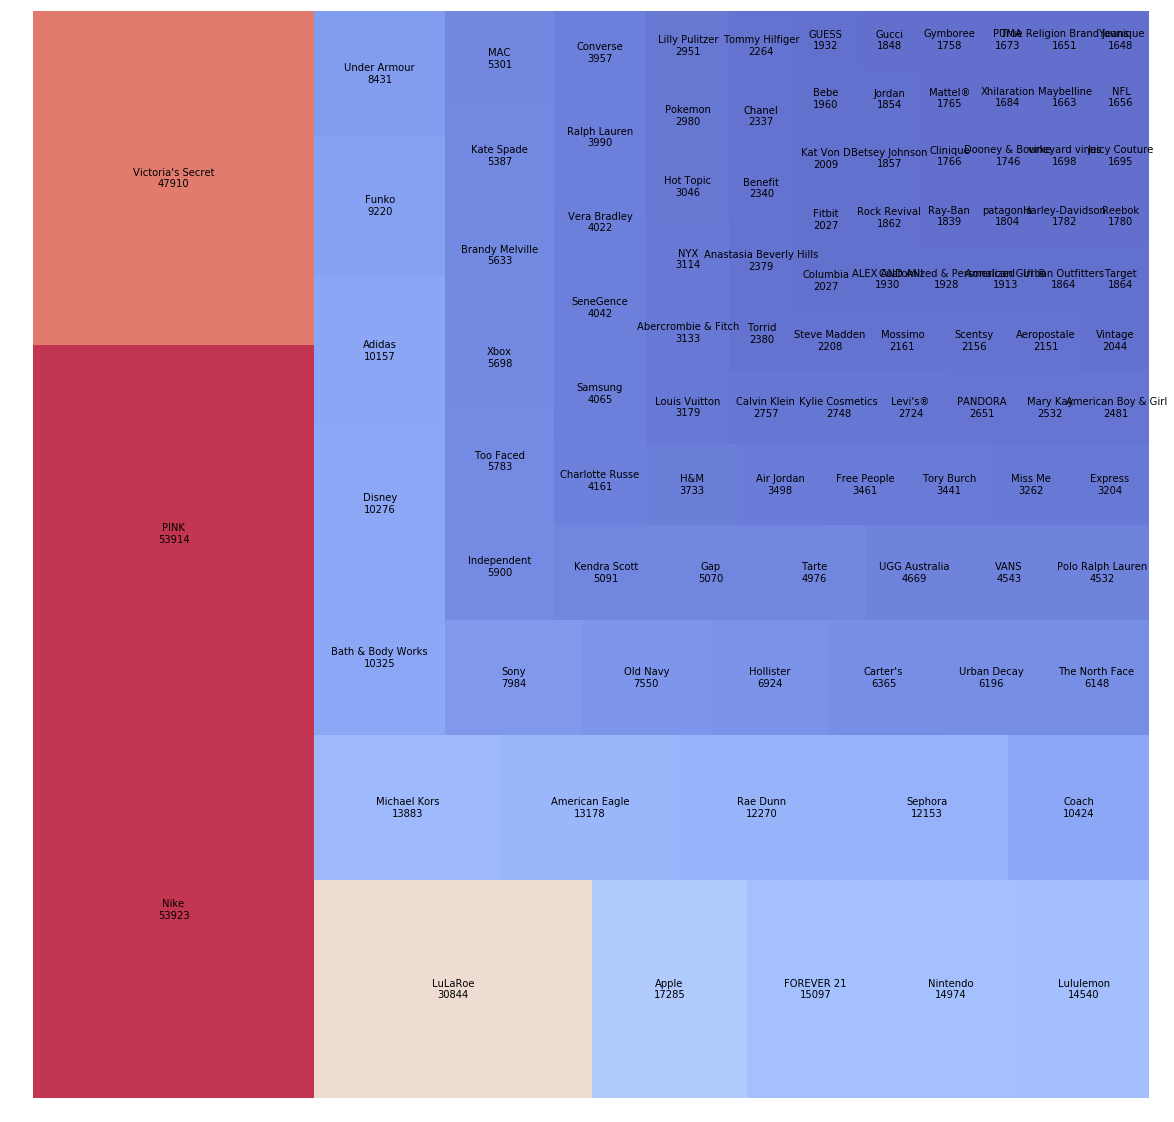

In [63]:
# Another visualisation for plotting more brands (100 brands) using a treemap

toPlot = nb_items_brand.sort_values('name', ascending=0).head(100)

mini=min(toPlot.name)
maxi=max(toPlot.name)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
cmap = matplotlib.cm.coolwarm
colors = [cmap(norm(value)) for value in toPlot.name]


labels = ["%s\n%d" % (label) for label in zip(toPlot.index, toPlot.name)]

plt.figure(figsize=(20,20))
squarify.plot(sizes=toPlot.name, label=labels, color=colors, alpha=.8)
plt.axis('off')

plt.show()

An important thing to do is to check if brand names are consistent : i.e. there is only **one** brand named **'Adidas'** and no 'Addidas', 'Addiddas', 'Adiddas', 'Adidass', etc.

Actually, this is the case with 'Adidas'.

In [64]:
#Check consistency of Brand names :
brand_names_array = np.sort(data_mercari.brand_name.unique())
Adidas_index = list(brand_names_array).index('Adidas')

brand_names_array[Adidas_index-4:Adidas_index+4]

array(['Adams Golf', 'Add Down', 'Addison', 'Adee Kaye', 'Adidas',
       'Adolfo', 'Adonna', 'Adora'], dtype=object)

However, even it seems that brand names are consistent in most cases, we sometimes spot errors on the go when exploring the dataset. For instance : **'Georgio Armani'** vs. **'Giorgio Armani'**.

There is two options : 
* either this is an error of some vendors on Mercari who mispelled the brand names,
* or it is due to counterfeit items sold on the website.

In [65]:
print(data_mercari[data_mercari.brand_name=='Georgio Armani'].price.describe(),'\n')
data_mercari[data_mercari.brand_name=='Georgio Armani'].head(10)

count    397.000000
mean      32.795970
std       49.319062
min        5.000000
25%       16.000000
50%       26.000000
75%       39.000000
max      917.000000
Name: price, dtype: float64 



,name,item_condition_id,main_cat,subcat_1,subcat_2,brand_name,price,shipping,item_description
252,Giorgio Armani Regenessence,1,Beauty,Makeup,Face,Georgio Armani,10.0,1,"Sample sized, never used Multi-firming rejuven..."
1123,GIORGIO ARMANI Sì Eau de Parfum,1,Beauty,Fragrance,Women,Georgio Armani,12.0,1,This listing is for: Brand New 0.24 oz GIORGIO...
10761,Emporio Armani,3,Beauty,Fragrance,Men,Georgio Armani,9.0,0,Black Jacket
13409,Georgia Armani Si,3,Beauty,Fragrance,Women,Georgio Armani,20.0,1,1 FL. OZ. Beautiful Georgio Armani Si parfum c...
16301,Giorgio Armani And MAC Bundle,2,Beauty,Makeup,Face,Georgio Armani,56.0,0,Amazing Giorgio Armani luminous silk foundatio...
18331,[rm] Acqua Di Gioia Jasmine. READ!!,1,Beauty,Fragrance,Women,Georgio Armani,22.0,1,More than half full. Bottle may have some scra...
26489,X3 giorgio armani etk mascara lot 2 ml,1,Beauty,Makeup,Eyes,Georgio Armani,14.0,1,Lot x 3 eyes to kill macara in shade black sam...
27675,Armani designer lift foundation,3,Beauty,Makeup,Face,Georgio Armani,36.0,0,Used a couple of times. Shade 3
27946,Acqua do gio for women 1.7 oz,1,Beauty,Fragrance,Women,Georgio Armani,32.0,0,Brand new 100% authentic sealed
29190,UNOPENED 1.7 Oz. Armani Sun di Gioia,1,Beauty,Fragrance,Women,Georgio Armani,50.0,1,"Unopened, brand new, still in packaging perfum..."


Prices seem to be coherent with the items sold, so there is a priori no issue of counterfeit goods. To deal with misspelling issues issue, we have 2 options :
* Rename all 'Georgio Armani' into 'Giorgio Armani' in order to ensure consistency within the whole data set. To do so we need to be able to automatically spot the misspelling errors in the dataset.
* Change nothing, with the idea that if the distibution of prices in 'Georgio Armani' items is the same as the distribution of prices in 'Giorgio Armani' items it will not change too much the quality of the price prediction we aim at performing.

Let's check the second option by plotting the boxplot of price distribution in Giorgio Armani vs. Georgio Armani.

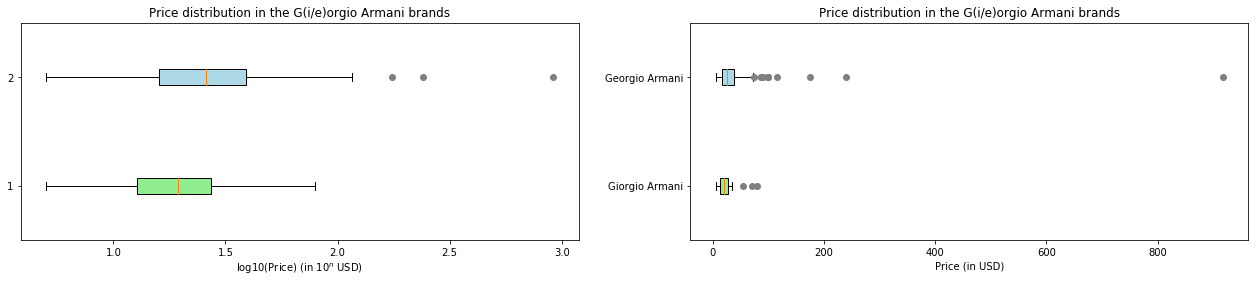

In [66]:
# Boxplot of price distribution in Giorgio Armani vs. Georgio Armani.

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(22,4))


# boxplot of log10(price)

axes[0].set_title('Price distribution in the G(i/e)orgio Armani brands')
brand_selection = ['Giorgio Armani','Georgio Armani']

toPlot1 = [np.array(np.log10(data_mercari.price[data_mercari.brand_name==bn])) for bn in brand_selection]
bplot1 = axes[0].boxplot(toPlot1, 0, 'grey', 0, patch_artist=True)
axes[0].set_xlabel('log10(Price) (in $10^n$ USD)')

colors = ['lightgreen','lightblue']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

    
# boxplot of Price

axes[1].set_title('Price distribution in the G(i/e)orgio Armani brands')
brand_selection = ['Giorgio Armani','Georgio Armani']

toPlot2 = [np.array(data_mercari.price[data_mercari.brand_name==bn]) for bn in brand_selection]
bplot2 = axes[1].boxplot(toPlot2, 0, 'grey', 0, patch_artist=True)
axes[1].set_xlabel('Price (in USD)')

colors = ['lightgreen','lightblue']
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

plt.yticks(range(1,len(brand_selection)+1),brand_selection)

plt.show()

It does not seem to be too critical to keep 'Georgio Armani' items separated from 'Giorgio Armani' ones as the price distributions are roughly the same. Still, we see that in doing so we will not take into account the outliers (very expensive products) and consequently undermine the "luxury" characteristic of the brand. For this reason it is reasonable to merge these two brands in one.

As mentionned before, we only spotted the "Giorgio" vs. "Georgio" case on the go while exploring the dataset. We need to develop a method for finding these errors automatically or at least semi-automatically.

Our strategy to do so is to :
1. Compute distances between brand names thanks to an ad-hoc metric.
* For all brands with small distances check by hand if it is due to a mispelling error or not.
* Merge brands that need to be merged.

#### 1) Compute distances
The metric we use is the [Levenstein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) : "Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other" (`source : wikipedia`).
The Levenshtein distance between two words $a$ and $b$ is given by $lev_{a,b}(\lvert a \rvert,\lvert b \rvert)$ where :
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f0a48ecfc9852c042382fdc33c19e11a16948e85"/>

The Levenshtein distance is accessible in the `nltk` (i.e. Natural Language Toolkit) package.

For performance reason, we think that it is time-consuming and useless to compute Levenshtein distances between all brand names which would recquire $\frac{4789 \times 4788}{2}$ computation of Levenshtein distances, each distance computation recquires $\Theta(\lvert word_i\rvert\times\lvert word_j\rvert)$ operations. So it can be very time consuming ...

To deal with this time-complexity, we sort brand names by asc. order and for each brand we compute its distance with its 100 predecessors and 100 successors. We assume that a 200-size-centered window is enough for spotting most of the misspelling errors - At least, as a sanity check, it enabled us to spot the Georgio / Giorgio error we previously mentionned.

In [174]:
#brand_names_array = np.sort(data_mercari.brand_name.unique())
m = np.mean(np.array(list(map(len,brand_names_array))))
print("In average, brand names are",m,"character-long" )

In average, brand names are 9.97962612896 character-long


In [359]:
#brand_names_array = np.sort(data_mercari.brand_name.unique())

# Compute a triangular matrix filled with Levensthein distance for brands
# The uncomputed distances are equal to Inf

N = len(brand_names_array)
brand_lev_distance = np.empty(shape=(N,N))
brand_lev_distance[:] = np.Inf
print("Start computing distances, it's going to take a few seconds ...")
for i in range(N):
    for j in range(i+1,i+100):
        if j<N:
            brand_lev_distance[i,j] = nltk.edit_distance(brand_names_array[i],brand_names_array[j])
print("Computing done. Thanks for waiting !")

# We save this computation in a .npy file in case we want to use it later on
np.save(arr=brand_lev_distance,file="brand_lev_distance")

Start computing distances, it's going to take a few seconds ...
Computing done. Thanks for waiting !


#### 2) Check (by hand) if similar brand names are similar because of an error or not.

We only consider very similar words with a distance = 1, and we write a small program to ask us if we want
* to merge
* not to merge
* or we have no idea about
two similar brands. The result is stored in a list that we save for future usage.


In [360]:
# We will check brands with very similar names (Levenshtein distance =1)

brand_to_merge = []
brand_to_check = []

toTest = np.argwhere(brand_lev_distance==1)
for b in toTest :
    print(brand_names_array[b[0]],brand_names_array[b[1]])
    flag = eval(input("Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)"))
    if (flag==1):
        brand_to_merge+=[(brand_names_array[b[0]],brand_names_array[b[1]])]
    if (flag==2):
        brand_to_check+=[(brand_names_array[b[0]],brand_names_array[b[1]])]

np.save(arr=brand_to_merge,file="brand_to_merge")
np.save(arr=brand_to_check,file="brand_to_check")

A+D AMD
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
A+D AND
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
A.L.C. A.P.C.
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
AMD AND
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
AND AND1
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)2
ASOS ASUS
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Alba Alia
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
All Alo
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
All Saints AllSaints
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)1
Aria Ariat
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Aria Ariya
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Aria Avia
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Ash Ask
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Athleta Athlete
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Ma

Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
REI REN
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Ravebsburger Ravensburger
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)1
Razer Razor
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Redington Remington
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Reed Reef
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Regal Regalo
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Revere Reverie
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Romy Roxy
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Rusk Russ
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Rustler Rustlers
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)2
Safety 1st Safety st
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)1
Saga Sega
Do you want to merge these 2 brands? (0=No, 1=Yes, 2=Maybe)0
Silhouette Silhouettes
Do you want 

In [385]:
# We check on Google if there is a misspelling
# We check if the items sold in Brand i and brand j are similar

for b in brand_to_check :
    print(data_mercari[data_mercari.brand_name==b[0]].head(1)[['name','main_cat','subcat_1','subcat_2','brand_name','price','item_description']])
    print()
    print(data_mercari[data_mercari.brand_name==b[1]].head(1)[['name','main_cat','subcat_1','subcat_2','brand_name','price','item_description']])
    print()
    flag = eval(input('Do you want to merge these 2 brands? (Yes=1, No=0)'))
    if flag==1:
        brand_to_merge += [b]

np.save(arr=brand_to_merge,file="brand_to_merge")

                                name main_cat          subcat_1 subcat_2  \
106889  AND1 white basketball shorts      Men  Athletic Apparel   Shorts   

       brand_name  price                                   item_description  
106889        AND   12.0  Only worn a few times, like new. Size M Price ...  

                               name main_cat subcat_1  subcat_2 brand_name  \
2771  And1 sandals for men Size: 10      Men    Shoes  Athletic       AND1   

      price                            item_description  
2771   14.0  Brand new men sandals Size 10 Brand : AND1  

Do you want to merge these 2 brands? (Yes=1, No=0)1
                                       name main_cat subcat_1  \
24817  Super Soft Plush Gray Blanket - NEW!     Home  Bedding   

                subcat_2 brand_name  price  \
24817  Blankets & Throws     Cannon   12.0   

                            item_description  
24817  Brand new!! Gray blanket Super soft!!  

                            name main_cat    

Do you want to merge these 2 brands? (Yes=1, No=0)1
                           name main_cat subcat_1      subcat_2  brand_name  \
141965  Red High Waisted Shorts    Women    Jeans  Slim, Skinny  Silhouette   

        price                                   item_description  
141965    9.0  New with tags, never worn • Best fit for sizes...  

            name main_cat        subcat_1 subcat_2   brand_name  price  \
1248268  ON HOLD    Women  Tops & Blouses    Other  Silhouettes   59.0   

                                          item_description  
1248268  This bundle is for 11 items Willing to bundle....  

Do you want to merge these 2 brands? (Yes=1, No=0)1
                                  name main_cat subcat_1            subcat_2  \
2048  Sperry boat shoes leopard detail    Women    Shoes  Loafers & Slip-Ons   

     brand_name  price                                   item_description  
2048     Sperry   24.0  Women's Sperry boat shoes tan color with leopa...  

              na

#### 3) Merge brands

Eventually the brands to merge are listed below. We then reorder them by hand for merging them more easily

In [9]:
brand_to_merge

array([['All Saints', 'AllSaints'],
       ['B Darlin', 'B. Darlin'],
       ['Chan Luu', 'Chann Luu'],
       ['Chloe', 'Chloé'],
       ['Cover Girl', 'CoverGirl'],
       ['DKNY', 'DKNYC'],
       ['Earl Jean', 'Earl Jeans'],
       ['Georgio Armani', 'Giorgio Armani'],
       ['Hanna Anderson', 'Hanna Andersson'],
       ['Heart Soul', 'HeartSoul'],
       ['J. Crew', 'J.Crew'],
       ['Kipling', 'Kiplling'],
       ['Lancome', 'Lancôme'],
       ['Philips', 'Phillips'],
       ['Quicksilver', 'Quiksilver'],
       ['Ravebsburger', 'Ravensburger'],
       ['Safety 1st', 'Safety st'],
       ['Spin Master', 'Spin Masters'],
       ['Stussy', 'Stüssy'],
       ['Threads  Thought', 'Threads 4 Thought'],
       ['Universal Studios', 'Univsersal Studios'],
       ['AND', 'AND1'],
       ['Jordan', 'Jordans'],
       ['KR3W', 'KRW'],
       ['Rustler', 'Rustlers'],
       ['Silhouette', 'Silhouettes'],
       ['Sperry', 'Sperrys'],
       ['Stampd', 'Stamped']],
      dtype='<U18')

In [77]:
#put the brand to merge in 
to_change=[0,1,3,6,7,8,9,10,12,14,15,18,19,20,21]

for i in to_change :
    brand_to_merge[i][0],brand_to_merge[i][1] = brand_to_merge[i][1],brand_to_merge[i][0]


In [79]:
# Merge brands

for b in brand_to_merge :
    data_mercari.brand_name.replace(b[1], b[0], inplace=True)

In [80]:
# Sanity check

b=['Giorgio Armani', 'Georgio Armani']
print('brand name = Georgio Armani')
print(data_mercari[data_mercari.brand_name == b[1]].brand_name.head(5))
print('vs.brand name = Giorgio Armani')
print(data_mercari[data_mercari.brand_name == b[0]].brand_name.head(5))

brand name = Georgio Armani
Series([], Name: brand_name, dtype: object)
vs.brand name = Giorgio Armani
252      Giorgio Armani
1123     Giorgio Armani
10761    Giorgio Armani
13409    Giorgio Armani
16301    Giorgio Armani
Name: brand_name, dtype: object


In [81]:
# Save data in a pickle file
data_mercari.to_pickle("data_mercari_removeNanSeparateCat_removeFree_brandNamesCleaned.pickle")

Now that we have cleaned the brand names, we can perform some analysis on the correlations between brands and price. For this purpose we plot the boxplot of price distribution in a selection of the following well-known brands : `['Nike','Adidas','LEGO','Apple', 'Samsung','Sephora','Tiffany & Co.','H&M',"Levi's®",'Louis Vuitton','Chanel']`.

We observe that brands (much more than categories) have a strong influence on the prices of the items.

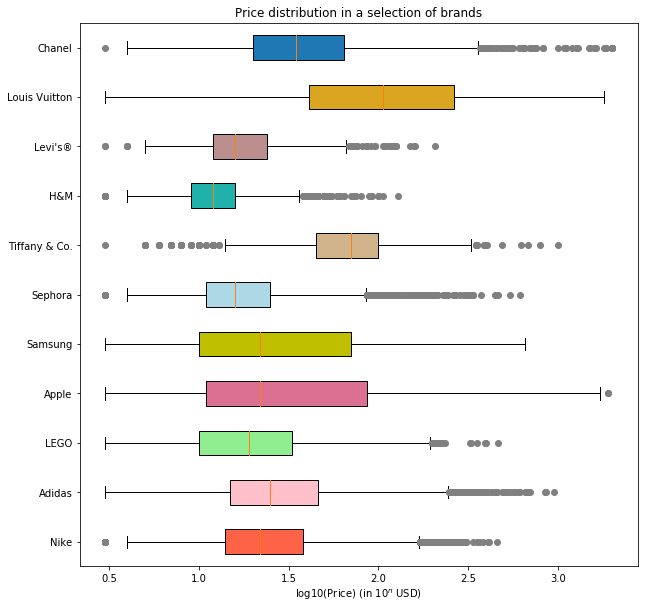

In [82]:
plt.figure(figsize=(10,10)) 

plt.title('Price distribution in a selection of brands')
brand_selection = ['Nike','Adidas','LEGO','Apple', 'Samsung','Sephora','Tiffany & Co.','H&M',"Levi's®",'Louis Vuitton','Chanel']
toPlot = [np.array(np.log10(data_mercari.price[data_mercari.brand_name==bn])) for bn in brand_selection]
bplot = plt.boxplot(toPlot, 0, 'grey', 0, patch_artist=True)
plt.xlabel('log10(Price) (in $10^n$ USD)')
plt.yticks(range(1,len(brand_selection)+1),brand_selection)

colors = ['tomato','pink','lightgreen','palevioletred','y','lightblue','tan','lightseagreen','rosybrown','goldenrod']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

# Items and items description

In [ ]:
# >> Checker ce qui se fait sur Kaggle : on rentre dans le dur

/Users/sachaizadi/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


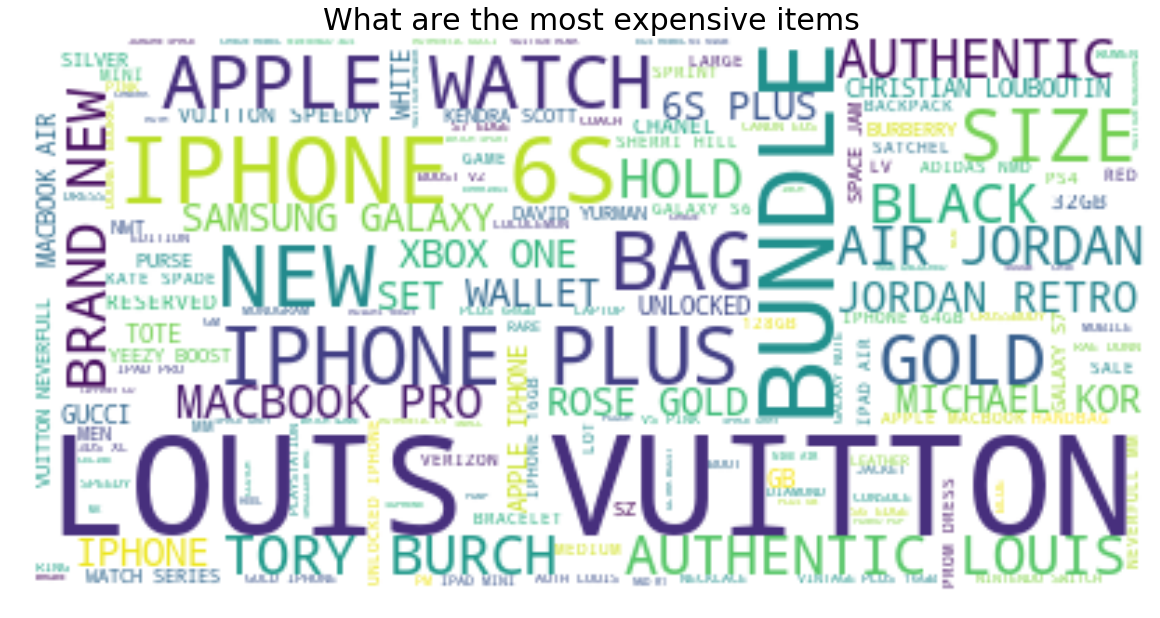

In [83]:
#Most expensive items
exp = data_mercari[data_mercari['price'] > 200]
exp.name = exp.name.str.upper()

wc = WordCloud(background_color="white", max_words=5000, max_font_size= 50)

wc.generate(" ".join(str(s) for s in exp.name.values))

plt.figure(figsize=(20,12))
plt.title('What are the most expensive items', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

In [84]:
# For easier access to description, we reindex the DataFrame
data_mercari['reindex']=range(1,data_mercari.shape[0]+1)
data_mercari.set_index('reindex',inplace=True)

The main challenge of this dataset is to deal with the items description which represent unstructured data. The difficulty here lies in the fact that the way products are described is not standardized at all ! There is as many description styles as there are vendors on Mercari. Let's have a look on some description styles we spotted on the go.

In [85]:
print('*** Some vendors indicate the price in the description - which was removed for this challenge, see the [rm] ***')
print(data_mercari.item_description.iloc[5])
print('\n')
print('*** Some vendors talk about themselves rather than the products and use emojis ***')
print(data_mercari.item_description.iloc[17])
print('\n')
print('*** Some vendors only mention the products characteristics ***')
print(data_mercari.item_description.iloc[21])
print('\n')
print('*** Some vendors use special characters for appealing the buyers ***')
print(data_mercari.item_description.iloc[846455])

*** Some vendors indicate the price in the description - which was removed for this challenge, see the [rm] ***
0.25 oz Full size is 1oz for [rm] in Sephora


*** Some vendors talk about themselves rather than the products and use emojis ***
lanascloset ~~~ description: never worn! ✨ i delete/update my listings and relist them so like my “sold” listings to have easier access to my shop later on ~~~ ✨ i normally ship the following day, but it happens that i ship a few days after purchase ~~~ forever 21 brandy Melville baseball tee


*** Some vendors only mention the products characteristics ***
Beautiful Excellent condition Zips and ties in the back Cream liner top to bottom


*** Some vendors use special characters for appealing the buyers ***
▪️NWOT ▪️Perfect Condition ▪️Barely been worn ▪️No flaws ▪️Not Nike from Stadium Athletics ▪️No pockets, great for leisure wear


We will need to structure this data for having the more insights as possible. A classical basic approach consists in removing all the "noise" within text to only keep words that describe best the items. For instance 

    "This AUTHENTIC pallete by Too Faced is brand new in mint condition still in original box. It\'s part of the. Christmas 2016 collection. It has 12 pretty eye shadow colors and a small sized"Better Than Sex" mascara. Never even swatched. Impeccable shape. Price includes 2 day priority shipping with insurance."

will turn in

    "authentic pallete too faced brand new mint condition original box part christmas 2016 collection 12 pretty eye shadow colors small sized better than sex mascara never even swatched impeccable shape price includes 2 day priority shipping insurance"


The steps will be

1. Remove all special characters (emojis, shapes ...), lower case, remove punctuation.
2. Remove stop words (i.e. very common words in english) such as 'i', 'it', 'what', 'is', etc. One challenging aspect regarding stop words is not to delete the negation words such as 'not', 'no', 'never', etc. which completely chang the meaning of a sentence : `'Not worn shirt'` ≠ `'worn shirt'`
3. Tokenize the description i.e. put it in a list of words. This can be a critical part: Should we separate all words? Keep some of them together (like 'Not worn' instead of 'not','worn' or '12 oz' instead of '12','oz' ...)
4. Continue the processing with other steps we will mention later on.

In [86]:
# We need to remove the '[rm]'s in item_description.

# First, let's have some basic statistics about the use of price within item_description:

def findRm(string):
    return(string.find('[rm]')>=0)

percentage_rm = sum(data_mercari.item_description.map(findRm))/data_mercari.shape[0]*100
print("There is ", round(percentage_rm), "% of the item descriptions containing Price indications")



There is  9.0 % of the item descriptions containing Price indications


In [87]:
# Then let's remove them
def replaceRm(string):
    return(string.replace(' [rm]',''))

data_mercari.item_description = data_mercari.item_description.map(replaceRm)

In [88]:
# Lower case, remove special characters, remove punctuation ... but keep decimal separator in decimal numbers (0.25)
string_to_modify = data_mercari.item_description.iloc[5]+'. '
print("Initial description:\n",string_to_modify)
print("Cleaned description:\n", \
      re.sub('[^A-Za-z0-9.]+|(?<!\d)\.(?!\d)',' ', string_to_modify).lower(),'\n')


def lowerCaseRemoveSpecial(string):
    return(re.sub('[^A-Za-z0-9.]+|(?<!\d)\.(?!\d)',' ', string).lower())

print('Please wait a couple seconds, we are processing the item_description ...')
data_mercari.item_description = data_mercari.item_description.map(lowerCaseRemoveSpecial)
print('We are done. Thanks for having waited.')


Initial description:
 0.25 oz Full size is 1oz for in Sephora. 
Cleaned description:
 0.25 oz full size is 1oz for in sephora   

Please wait a couple seconds, we are processing the item_description ...
We are done. Thanks for having waited.


In [89]:
# Save data in a pickle file
data_mercari.to_pickle("data_mercari_removeNanSeparateCat_removeFree_brandNamesCleaned_itemDescriptionCleaned.pickle")

In order to remove the stopwords we will use the collection of the english stopwords provided in the nltk library. Furthermore, it seems to be quite inefficient to remove stop words directly in a string, the best solution is to tokenize the descriptions, then to remove stopwords.

**⚠ you will probably need to download some features for `nltk` :**
* **`nltk.download("stopwords")`**
* **`nltk.download("punkt")`**

To do so, just uncomment the first lines of code of the next chunks. Thanks.


In [90]:
##### If needed, download the english stopwords collection by uncommenting next line ######
#nltk.download("stopwords")

# Let's have a look at this collection:
print(nltk.corpus.stopwords.words('english'))
print('\n')

# As mentionned previously, we will keep the 'no' and 'not' words in order no to bias a description 
#("Not worn shirt" ≠ "Worn shirt")

print("Number of stopwords in the collection:", len(nltk.corpus.stopwords.words('english')),'\n')

stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove('no')
stopwords.remove('not')
print("Number of stopwords in the collection (we removed 'no' & 'not'):", len(stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [91]:
##### If needed, download the english stopwords collection by uncommenting next line ######
#nltk.download("punkt")

print("Please wait while we're tokenizing the item_description. It's going to take a few seconds ...")
data_mercari.item_description = data_mercari.item_description.map(nltk.word_tokenize)
print("Tokenization done! Thanks for having waited.")

Please wait while we're tokenizing the item_description. It's going to take a few seconds ...
Tokenization done! Thanks for having waited.


In [93]:
# Now let's remove the stopwords in the tokenized item_description

print('*** Unfiltered tokenized item description ***')
print(data_mercari.item_description.iloc[1])
print('\n')
print('*** Filtered tokenized item description ***')
filtered_token = [w for w in data_mercari.item_description.iloc[1] if not w in stopwords]
print(filtered_token)
print('\n')

def filterStopWords(token):
    return([w for w in token if not w in stopwords])

print("Please wait while we're filtering the tokenized item_description. It's going to take a few seconds ...")
data_mercari.item_description = data_mercari.item_description.map(filterStopWords)
print("Tokenization done! Thanks for having waited.")


*** Unfiltered tokenized item description ***
['adorable', 'top', 'with', 'a', 'hint', 'of', 'lace', 'and', 'a', 'key', 'hole', 'in', 'the', 'back', 'the', 'pale', 'pink', 'is', 'a', '1x', 'and', 'i', 'also', 'have', 'a', '3x', 'available', 'in', 'white']


*** Filtered tokenized item description ***
['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', '1x', 'also', '3x', 'available', 'white']


Please wait while we're filtering the tokenized item_description. It's going to take a few seconds ...
Tokenization done! Thanks for having waited.


In [94]:
# Save data in a pickle file
data_mercari.to_pickle("data_mercari_removeNanSeparateCat_removeFree_brandNamesCleaned_itemDescriptionCleaned_tokenizedNoStopWord.pickle")

For the moment we keep tokens as they currently are. The main challenges for being able to predict prices given a description will be :
* to understand, learn and extract quantities and other quantitative features : this item `['0.5', 'oz', 'full', 'size', '1oz', 'sephora']` is probably $2\times$ more expensive than this one `['0.25', 'oz', 'full', 'size', '1oz', 'sephora']`
* to understand and learn that `['barely', 'worn']`, `[worn, one, time, excellent, condition]` and `['not','worn']` are more or less equivalent.

In [ ]:
# TO do : wordclouds
# Maybe ? Stemming --> extract roots


In [182]:
data_mercari.item_description

reindex
1         [keyboard, great, condition, works, like, came...
2         [adorable, top, hint, lace, key, hole, back, p...
3         [size, small, straps, slightly, shortened, fit...
4         [get, three, pairs, sophie, cheer, shorts, siz...
5         [girls, size, small, plus, green, three, short...
6                      [0.25, oz, full, size, 1oz, sephora]
7         [5, new, vs, pink, body, mists, 2.5, oz, fresh...
8                                    [xl, great, condition]
9                                    [no, description, yet]
10        [authentic, suede, fringe, boots, great, condi...
11        [brand, new, deluxe, travel, size, products, c...
12        [2, glitter, eyeshadows, one, brass, one, blea...
13        [authentic, pallete, faced, brand, new, mint, ...
14        [fancy, dressy, casual, dress, 100, polyester,...
15                   [size, 1., worn, excellent, condition]
16        [nwt, victoria, secret, ultimate, sport, bra, ...
17        [reasonable, offers, w

Attention aux emoji dans les textes : 1024458

### Data visualisation and representation
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

In [ ]:
### write code here (use as many cells as needed)



### Data consistency checking
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

In [ ]:
### write code here (use as many cells as needed)



### Estimation question
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

In [ ]:
### write code here (use as many cells as needed)



### As many other optional questions as you want
** <span style="color:red"> Write explanations here</span> ** 
* 
* 
* 

In [31]:
# Opening the Pickle data
with open("data_mercari_removeNanSeparateCat_removeFree_brandNamesCleaned_itemDescriptionCleaned_tokenizedNoStopWord.pickle", 'rb') as f:
    data_mercari = pickle.load(f)